In [1]:
from mpi4py import MPI
import os
import json
import copy
import time
from collections import OrderedDict

import numpy as np
import pandas as pd
from scipy.integrate import odeint, solve_ivp

import sys
sys.path.append("../")

from src.model.maleckar import init_states_constants, compute_rates, legend
from src.helpers import get_value_by_key, update_array_from_kwargs,\
    calculate_RMSE, calculate_RMSE_balanced, flatten_iterable, batches_from_list, value_from_bounds
from src.algorythm.ga import do_step

from matplotlib import pyplot as plt
from tqdm import tqdm

import pickle

In [150]:
with open("cases/maleckar/output_rtol/backup.pickle", "rb") as f:
    population = pickle.load(f)

In [3]:
config_filename = "cases/maleckar/v0/config_MOP_copy.json"
config_path = os.path.dirname(os.path.realpath(config_filename))

with open(config_filename) as f:
    config = OrderedDict(json.load(f))
    
for exp_cond in config['experimental_conditions']:
    CL = exp_cond['CL']
    filename_phenotype = os.path.join(config_path, exp_cond['filename_phenotype'])
    exp_cond['phenotype'] = np.loadtxt(filename_phenotype)
    filename_state = os.path.join(config_path, exp_cond['filename_state'])
    exp_cond['initial_state'] = np.loadtxt(filename_state)

In [12]:
dump = np.fromfile("./cases/maleckar/output_MOP_copy_nomut_continue/dump.bin")
n_genes = len(config['multipliers']) + sum(len(exp_conf['params']) for exp_conf in config['experimental_conditions'] if 'params' in exp_cond)
n_org = config['n_organisms']
n_elites = config['n_elites'] # n_org // 16
dump = dump.reshape(-1, n_org, n_genes + 1)
print(dump.shape)

(190, 6000, 15)


In [17]:
dump.shape

(273, 6000, 15)

In [16]:
dump = np.concatenate([dump0, dump], axis=0)

In [14]:
dump0.shape

(83, 6000, 15)

In [10]:
dump0 = dump.copy()

In [584]:
dump = np.fromfile("./cases/maleckar/output/dump")
n_genes = len(config['multipliers']) + sum(len(exp_conf['params']) for exp_conf in config['experimental_conditions'] if 'params' in exp_cond)
n_org = config['n_organisms'] // 2
n_elites = config['n_elites'] # n_org // 16
dump = dump.reshape(-1, n_org, n_genes + 1)
print(dump.shape)

(507, 6000, 15)


In [152]:
dumps = [np.fromfile("./cases/maleckar/output_MOP_copy/dump.bin"),
         np.fromfile("./cases/maleckar/output_MOP/dump.bin"),
         np.fromfile("./cases/maleckar/output_rtol_continue/dump.bin")]
n_genes = len(config['multipliers']) + sum(len(exp_conf['params']) for exp_conf in config['experimental_conditions'] if 'params' in exp_cond)
#n_org = config['n_organisms'] // 2
#n_elites = config['n_elites'] # n_org // 16

dumps[0] = dumps[0].reshape(-1, 6000, n_genes + 1)
dumps[1] = dumps[1].reshape(-1, 2880, n_genes + 1)
dumps[2] = dumps[2].reshape(-1, 1440, n_genes + 1)

In [23]:
np.where(np.isinf(dump[:, :, -1]))

(array([], dtype=int64), array([], dtype=int64))

In [24]:
n_genes

14

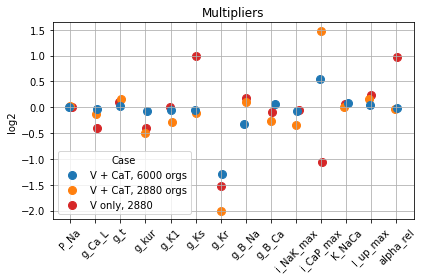

In [155]:
for i, dump in enumerate(dumps):
    x = np.arange(len(np.log2(dump[-1, 0, :-1])))
    x = x + np.random.randn(len(x)) * 0.05
    plt.plot(x, np.log2(dump[-1, 0, :-1]), 'o', ms=8, color=f"C{i if i < 2 else 3}", zorder=-i)
    #print(np.array2string(dump[-1, 0, :], precision=3)[1:-1])
plt.xticks(np.arange(len(multipliers_keys)), multipliers_keys, rotation=45)
plt.legend(['V + CaT, 6000 orgs', 'V + CaT, 2880 orgs', 'V only, 2880'], title='Case')
plt.grid()
plt.ylabel('log2')
plt.title('Multipliers')
plt.tight_layout()
plt.savefig("./images/maleckar/multipliers_2.png", dpi=300)

In [18]:
dumps = dump,

In [6]:
dump[-1, 0, :]

array([ 1.02436443,  0.91268935,  1.14378887,  0.74098341,  0.81830772,
        1.54045627,  0.31594501,  0.80726986,  0.8960847 ,  0.79424239,
        2.41122098,  0.95076891,  1.04476383,  1.02319307, -0.0143813 ])

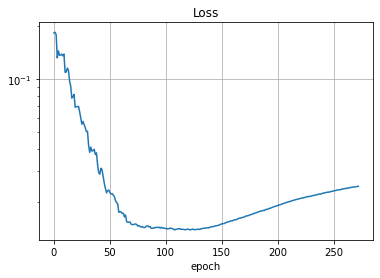

In [20]:
for i, dump in enumerate(dumps[:]):
    plt.semilogy(-dump[:, 0, -1], '-', label=str(i))
plt.xlabel('epoch')
plt.title('Loss')
plt.grid()
#plt.legend(title='Case')
plt.savefig(f"./images/maleckar/loss.png", dpi=300)

100%|██████████| 273/273 [02:26<00:00,  1.87it/s]


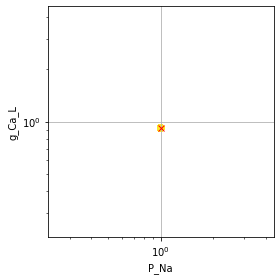

In [21]:
plt.figure(figsize=plt.figaspect(1))

i1, i2 = 0, 1
epoch = 0

scat = plt.scatter(dump[epoch, ::-1, i1], dump[epoch, ::-1, i2], c=dump[epoch, :, -1])
line_best, = plt.plot(dump[epoch, 0, i1], dump[epoch, 0, i2], 'xr')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(config['multipliers'][i1]['name'])
plt.ylabel(config['multipliers'][i2]['name'])

plt.tight_layout()


plt.axis('equal')
#plt.axis([6, 12, 0.01, 2])
#plt.axis([6, 12, 125, 135])

plt.grid()

for epoch in tqdm(range(0, dump.shape[0])):
    scat.set_offsets(dump[epoch, ::-1, [i1, i2]].T)
    scat.set_array(dump[epoch, :, -1])
    line_best.set_data(dump[epoch, 0, i1], dump[epoch, 0, i2])
    plt.savefig("./images/maleckar/pairplots/pairplot_{:04d}.png".format(epoch), dpi=300)

100%|█████████▉| 704/705 [02:37<00:00,  4.47it/s]


OSError: ./cases/maleckar/output_rtol/phenotype/phenotype_1000_704.txt not found.

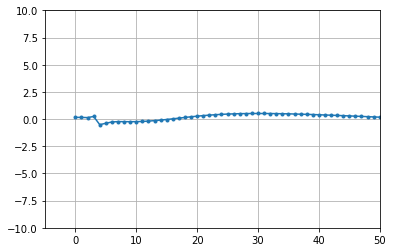

In [1080]:
CL = 1000

v = np.loadtxt(f"./cases/maleckar/output_rtol/phenotype/phenotype_{CL}_{0}.txt")
baseline = np.loadtxt(f"./cases/maleckar/v0/baselines/baseline_{CL}.txt")

time = np.arange(len(baseline))
line, = plt.plot(time, v[:len(baseline)] - baseline, '.-')
plt.grid()
plt.xlim(-5, 50)
plt.ylim(-10, 10)


for epoch in tqdm(range(0, dump.shape[0])):
    v = np.loadtxt(f"./cases/maleckar/output_rtol/phenotype/phenotype_{CL}_{epoch}.txt")
    baseline = np.loadtxt(f"./cases/maleckar/v0/baselines/baseline_{CL}.txt")
    line.set_data(time, v[:len(baseline)] - baseline)
    plt.savefig("./images/waveform_{:04d}.png".format(epoch), dpi=300)

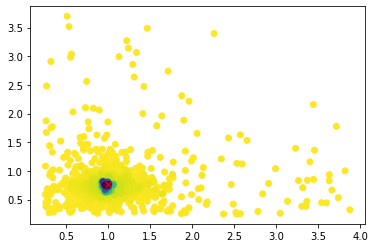

In [388]:
scat = plt.scatter(dump[epoch, ::-1, i1], dump[epoch, ::-1, i2], c=dump[epoch, :, -1])
line_best, = plt.plot(dump[epoch, 0, i1], dump[epoch, 0, i2], 'xr')

In [37]:
dump[-1]

array([[ 1.00632092e+00,  9.69477995e-01,  1.05032093e+00, ...,
         1.01938579e+00,  1.00536264e+00, -5.95513074e-03],
       [ 1.00604724e+00,  9.69372812e-01,  1.05030004e+00, ...,
         1.01935394e+00,  1.00542085e+00, -5.95526797e-03],
       [ 1.00433528e+00,  9.85068462e-01,  1.04427719e+00, ...,
         1.00221670e+00,  9.93705876e-01, -6.00222098e-03],
       ...,
       [ 7.42522467e-01,  3.21639379e+00,  2.89632624e-01, ...,
         7.98731179e-01,  2.76882911e+00, -6.27124333e+01],
       [ 1.35733792e+00,  2.80479769e+00,  4.02133854e-01, ...,
         8.31557176e-01,  1.20627152e+00, -7.06029882e+01],
       [ 1.17244430e+00,  3.01835615e+00,  1.64431034e+00, ...,
         2.64180959e-01,  3.94789443e+00, -8.77275338e+01]])

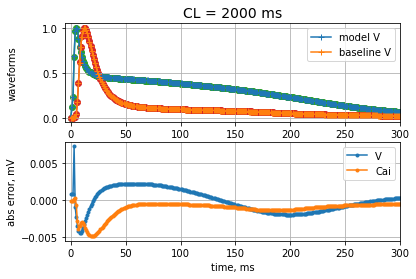

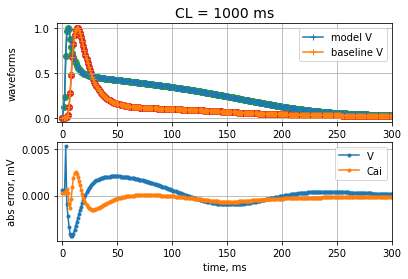

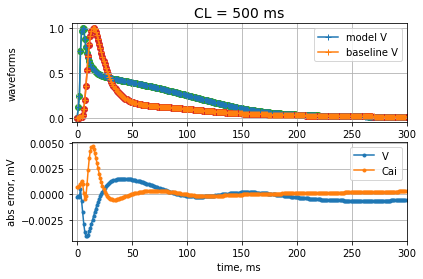

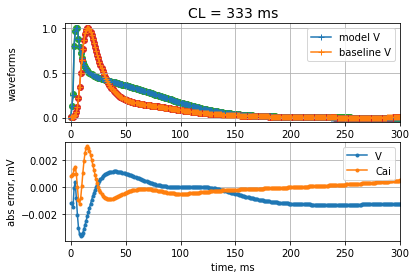

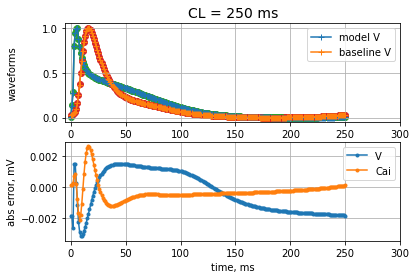

In [40]:
df_best = pd.DataFrame(index=legend['states']['name'])

#dump = dumps[-1]
epoch = len(dump) - 2

for exp_cond in config['experimental_conditions']:
    
    fig, axes = plt.subplots(2, 1)

    
    CL = exp_cond['CL']
    
    #if CL == 333:
    #    continue

    v = np.loadtxt(f"./cases/maleckar/output_MOP_ctypes/phenotype/phenotype_{CL}_{epoch}.txt")
    state = np.loadtxt(f"./cases/maleckar/output_MOP_ctypes/state/state_{CL}_{epoch}.txt")
    baseline = exp_cond['phenotype']
    #print(state)

    x, y = v, baseline
    x = (x - y.min(axis=0)) / y.ptp(axis=0)
    y = (y - y.min(axis=0)) / y.ptp(axis=0)
    v, baseline = x, y
    
    df_best[CL] = state
    
    #AP = np.loadtxt(f"./cases/maleckar/baselines/AP_{CL}.txt")
    #np.savetxt(f"./cases/maleckar/baselines/AP_{CL}.txt", AP)

    
    plt.sca(axes[0])
    plt.plot(v, '+-')
    plt.plot(baseline, 'o-', zorder=-10)

    #plt.plot(AP)
    plt.title(f'CL = {CL} ms', size=14)
    plt.xlim(-5, 300)
    plt.ylabel('waveforms')
    #plt.savefig(f"./cases/maleckar/waveform_{CL}.png")
    plt.grid()
    plt.legend(['model V','baseline V'])
    
    plt.sca(axes[1])
    plt.plot((v[:len(baseline)] - baseline), '.-')
    #print(calculate_RMSE_balanced(v[10:len(baseline)], baseline[10:]))
    plt.ylabel('abs error, mV')
    plt.xlim(-5, 300)
    plt.grid()
    plt.legend(['V', 'Cai'])
    plt.xlabel('time, ms')
    fig.align_labels()

    plt.savefig(f"./images/maleckar/waveforms_errors_v/{CL}_{epoch}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [17]:
for i, name in enumerate(legend['states']['name']):
    print(f'atol[{i}] = 1e-6;{" " * (8 - (i >= 10))}rtol[{i}] = 1e-6;  // {name}')

atol[0] = 1e-6;        rtol[0] = 1e-6;  // V
atol[1] = 1e-6;        rtol[1] = 1e-6;  // Na_c
atol[2] = 1e-6;        rtol[2] = 1e-6;  // Na_i
atol[3] = 1e-6;        rtol[3] = 1e-6;  // m
atol[4] = 1e-6;        rtol[4] = 1e-6;  // h1
atol[5] = 1e-6;        rtol[5] = 1e-6;  // h2
atol[6] = 1e-6;        rtol[6] = 1e-6;  // Ca_d
atol[7] = 1e-6;        rtol[7] = 1e-6;  // d_L
atol[8] = 1e-6;        rtol[8] = 1e-6;  // f_L1
atol[9] = 1e-6;        rtol[9] = 1e-6;  // f_L2
atol[10] = 1e-6;       rtol[10] = 1e-6;  // K_c
atol[11] = 1e-6;       rtol[11] = 1e-6;  // K_i
atol[12] = 1e-6;       rtol[12] = 1e-6;  // r
atol[13] = 1e-6;       rtol[13] = 1e-6;  // s
atol[14] = 1e-6;       rtol[14] = 1e-6;  // a_ur
atol[15] = 1e-6;       rtol[15] = 1e-6;  // i_ur
atol[16] = 1e-6;       rtol[16] = 1e-6;  // n
atol[17] = 1e-6;       rtol[17] = 1e-6;  // pa
atol[18] = 1e-6;       rtol[18] = 1e-6;  // Ca_c
atol[19] = 1e-6;       rtol[19] = 1e-6;  // Ca_i
atol[20] = 1e-6;       rtol[20] = 1e-6;  // O_C
atol[2

In [30]:
df_best

,2000,1000,500,333,250
name,,,,,
V,-72.916871,-72.631885,-70.855550,-67.803284,-64.759276
Na_c,130.017273,130.012871,129.998994,129.987235,129.980774
Na_i,7.712191,8.354855,9.452518,10.229132,10.602563
m,0.003765,0.003898,0.004835,0.006996,0.010104
h1,0.852816,0.845615,0.794562,0.689775,0.555568
h2,0.852407,0.841304,0.729881,0.544165,0.364499
Ca_d,0.000060,0.000070,0.000106,0.000166,0.000227
d_L,0.000016,0.000017,0.000023,0.000039,0.000066
f_L1,0.998359,0.998290,0.997799,0.996666,0.994455


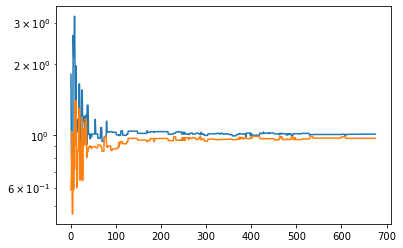

In [31]:
plt.semilogy(dump[:, 0, :2])
#plt.legend(multipliers_keys[:n_genes])
#plt.savefig(f"./cases/maleckar/params_{CL}.png")

# Preparing baselines

In [22]:
def run_model(S, C, R, A, config, legend, only_last_beat=True):

    stim_period = get_value_by_key(C, legend['constants'], 'stim_period')
    # stim_duration = get_value_by_key(C, legend['constants'], 'stim_duration')
    t_sampling = config['t_sampling']
    n_beats = config['n_beats']

    t_space = np.linspace(0, stim_period * n_beats, int(stim_period / t_sampling) * n_beats + 1, endpoint=True)
    t_tail = np.linspace(stim_period * (n_beats - 1), stim_period * n_beats, int(stim_period / t_sampling) + 1, endpoint=True)
    t_span = 0, t_space[-1]
    
    if only_last_beat:
        t_eval = t_tail
    else:
        t_eval = t_space

    sol = solve_ivp(compute_rates, y0=S,
                    t_span=t_span, t_eval=t_eval,
                    args=(C, R, A),
                    method='LSODA',# rtol=1e-9,
                    max_step=1. * t_sampling)
    return sol

In [23]:
multipliers_values = [0.85943678, 0.31528362, 0.37675159, 0.72384734, 0.30367057, 1.67148982,
                      3.12872977, 1.83017008, 2.40277891, 1.40863714, 1.60279321, 2.75621646,
                      1.22957867, 0.54994283]

In [24]:
multipliers_values = dump[-1, 0, :-1]

NameError: name 'dump' is not defined

In [25]:
multipliers_keys = ['P_Na', 'g_Ca_L',
          'g_t', 'g_kur', 'g_K1', 'g_Ks', 'g_Kr',
          'g_B_Na', 'g_B_Ca',
          'i_NaK_max', 'i_CaP_max', 'K_NaCa',
          'I_up_max', 'alpha_rel']

#multipliers_keys = ['P_Na', 'g_Ca_L', 'g_K1']

#multipliers_values = 0.7 + (1.3 - 0.7) * np.random.random(len(multipliers_keys))
multipliers_values = np.ones(len(multipliers_keys))
#multipliers_values = np.round(multipliers_values, decimals=2)

multipliers_dict = dict(zip(multipliers_keys, multipliers_values))

multipliers_dict['g_K1'] = 1.1
multipliers_dict['g_Ca_L'] = 0.5
multipliers_dict['K_NaCa'] = 1.3
multipliers_dict['alpha_rel'] = 1.2

S, C = init_states_constants()
R = np.zeros_like(S)
A = np.zeros(len(legend['algebraic']))

C_default = pd.Series(data=C, copy=True,
                      index=legend['constants']['name'])
update_kwargs = {}
for key in multipliers_dict:
    update_kwargs[key] = C_default[key] * multipliers_dict[key]
C = update_array_from_kwargs(C, legend['constants'], **update_kwargs)

In [4]:
S, C = init_states_constants()


In [12]:
legend_constants = pd.read_csv("../src/model_ctypes/_maleckar/legend_constants.csv")

In [14]:
legend_constants['value'] = C

In [15]:
legend_constants.to_csv("../src/model_ctypes/_maleckar/legend_constants.csv")

In [64]:
multipliers_dict

{'P_Na': 1.0,
 'g_Ca_L': 0.5,
 'g_t': 1.0,
 'g_kur': 1.0,
 'g_K1': 1.1,
 'g_Ks': 1.0,
 'g_Kr': 1.0,
 'g_B_Na': 1.0,
 'g_B_Ca': 1.0,
 'i_NaK_max': 1.0,
 'i_CaP_max': 1.0,
 'K_NaCa': 1.3,
 'I_up_max': 1.0,
 'alpha_rel': 1.2}

In [27]:
epoch = len(dump) - 1

NameError: name 'dump' is not defined

In [83]:
CL = 250
#S = np.loadtxt(f"cases/maleckar/output_MOP_copy/state/state_{CL}_{epoch}.txt")
S = np.loadtxt(f"cases/maleckar/v0/states/state_{CL}.txt")
#S = np.loadtxt(f"cases/maleckar/state_random_2_{CL}.txt")

In [92]:
n_beats = 1000
stim_period = CL/1000.
t_sampling = 1e-3

C = update_array_from_kwargs(C, legend['constants'], stim_period=stim_period)

config = dict(t_sampling=t_sampling,
              n_beats=n_beats)

sol = run_model(S, C, R, A, config, legend, only_last_beat=False)
res = sol.y

df = pd.DataFrame(res.T, columns=legend['states']['name'])
S = res[:, -1]
baseline = df['V'].values[-CL -1: -1]

In [93]:
x = res[[0, 19]].T

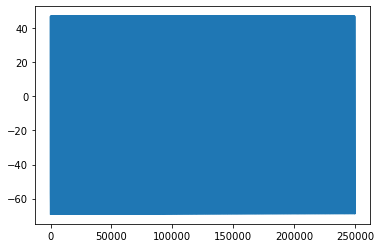

In [94]:
plt.plot(x[:, 0])

In [95]:
np.min(x, axis=0)

array([-6.90129362e+01,  9.04772939e-05])

In [96]:
#df[['V', 'Ca_i']].values[:1000]

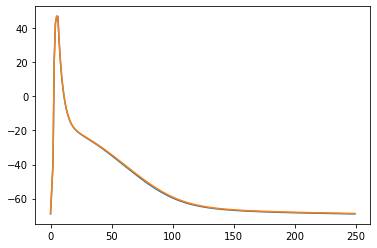

In [97]:
plt.plot(df['V'].values[:CL])
plt.plot(df['V'].values[-CL -1: -1])

-0.36813834170480014


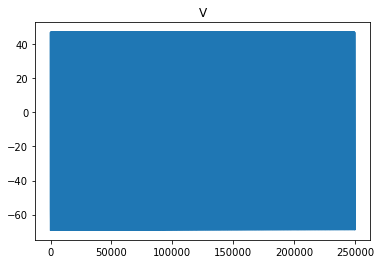

-1.849530720216316


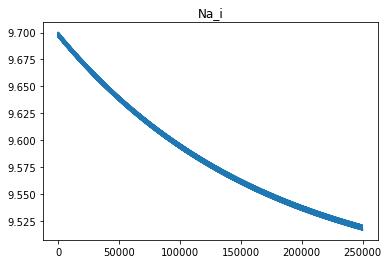

-5.011964081494054


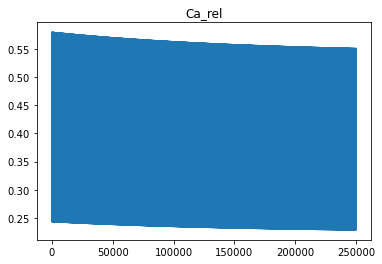

0.1497171737107122


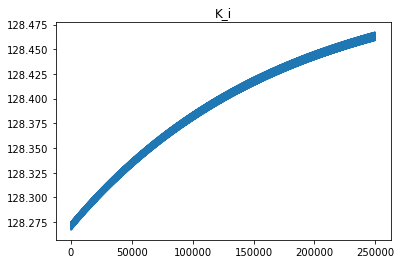

-3.336160443403692


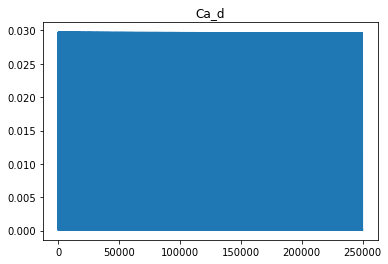

-4.10613852318715


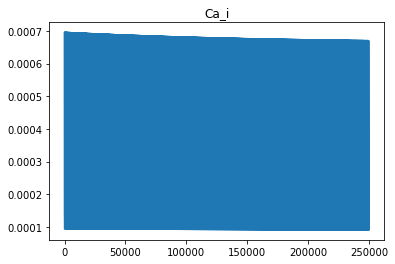

In [98]:
for name in 'V', 'Na_i', 'Ca_rel', 'K_i', 'Ca_d', 'Ca_i':
    plt.plot(df[name])
    first, last = df[name].iloc[[0, -1]]
    error_rel = (last - first) / first
    print(error_rel * 100)
    plt.title(name)
    plt.show()

In [99]:
np.savetxt(f"cases/maleckar/v1/baselines/V_Ca_i_{CL}.txt", df[['V', 'Ca_i']].values[:1000])
np.savetxt(f"cases/maleckar/v1/states/state_{CL}.txt", S)

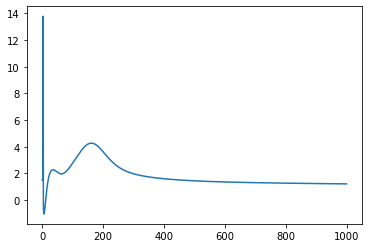

In [36]:
plt.plot(df['V'].values[:CL] - df['V'].values[-CL -1: -1])

In [37]:
#plt.plot(df['V'].values[-CL -1 - CL: -1 - CL] - df['V'].values[-CL -1: -1])

In [80]:
df_sol = df.copy()

-4.8349192136616405e-06
-0.025743036367797616


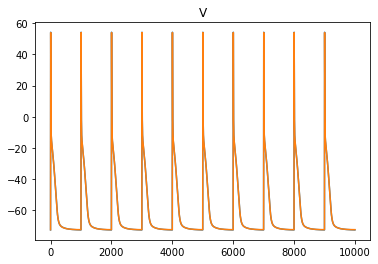

-1.0663179219893948e-05
-0.0022419034396755303


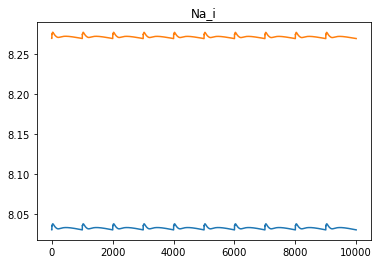

-7.769383325921441e-06
0.10933837393481


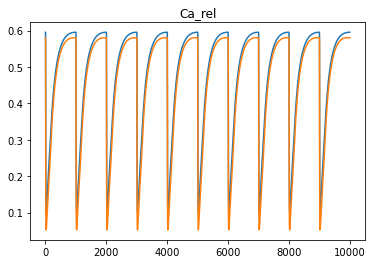

6.756100649420529e-07
-0.00010648367303195388


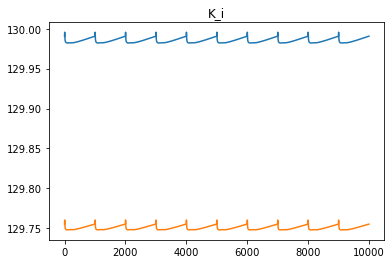

-2.926224198149816e-06
0.18698790399058096


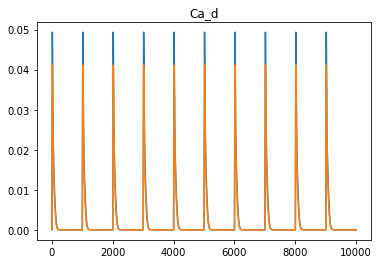

-1.0442046235624266e-05
0.17282564280483198


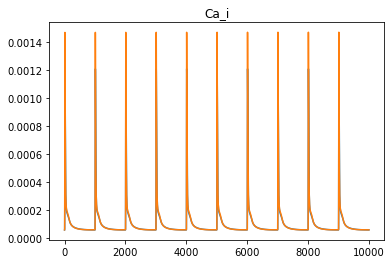

In [102]:
for name in 'V', 'Na_i', 'Ca_rel', 'K_i', 'Ca_d', 'Ca_i':
    for d in df, df_sol:
        plt.plot(d[name])
        first, last = d[name].iloc[[0, -1]]
        error_rel = (last - first) / first
        print(error_rel * 100)
    plt.title(name)
    plt.show()

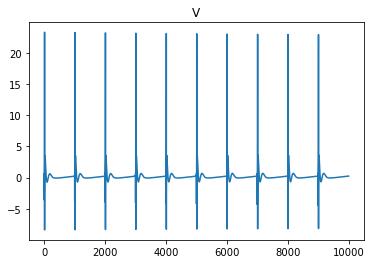

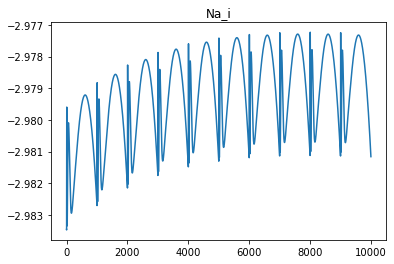

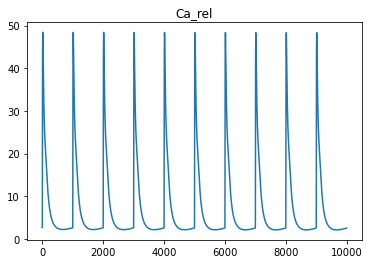

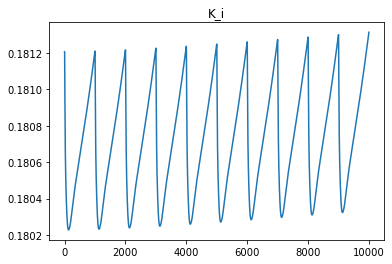

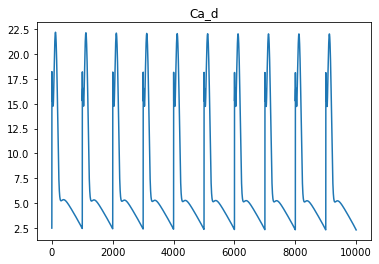

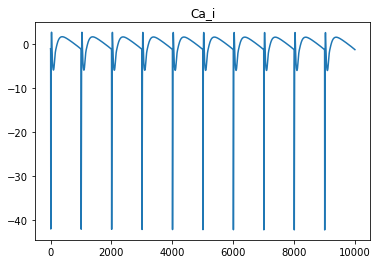

In [105]:
for name in 'V', 'Na_i', 'Ca_rel', 'K_i', 'Ca_d', 'Ca_i':
    plt.plot((df[name] - df_sol[name]) / df[name] * 100)
    plt.title(name)
    plt.show()

In [1188]:
#np.savetxt(f"cases/maleckar/state_random_2_{CL}.txt", S)

In [991]:
#np.savetxt(f"cases/maleckar/v0/baselines/baseline_{CL}.txt", baseline)
#np.savetxt(f"cases/maleckar/v0/states/state_{CL}.txt", S)

In [178]:
CL = 333
stim_period = CL/1000.
#stim_period = get_value_by_key(C, legend['constants'], 'stim_period')
t_sampling = 1e-3

S = np.loadtxt(f"cases/maleckar/v0/states/state_{CL}.txt")
C = update_array_from_kwargs(C, legend['constants'], stim_period=stim_period)

n_beats = 10
t_space = np.linspace(0, stim_period * n_beats, int(stim_period / t_sampling)*n_beats + 1, endpoint=True) 
tcrit = np.linspace(0, stim_period * n_beats, n_beats + 1, endpoint=True)

In [179]:
#def event(t, y, *args):
#    return (t - stim_period / 2 - 1e-6) % stim_period - 0.5

#event.terminal = False
#event.direction = 1

stim_duraion = 0.006
def event(t, y, *args):
    return not (0 <= t % stim_period <= stim_duraion)

event.terminal = False
event.direction = 0

In [180]:
t_space = np.linspace(0, stim_period * n_beats, int(stim_period / t_sampling)*n_beats + 1, endpoint=True) 
t_tail = np.linspace(stim_period * (n_beats - 1), stim_period * n_beats, int(stim_period / t_sampling) + 1, endpoint=True) 

t_span = 0, t_space[-1]
print(t_span)

kw_RK23 = dict(max_step=0.01 / 1000., rtol=1e-6, atol=1e-3, method='RK23')
kw_LSODE = dict(method='LSODA', max_step=0.9*stim_duraion)
kw_BDF = dict(method='BDF')

kw = kw_LSODE

(0, 3.33)


In [182]:
%%time

res = solve_ivp(compute_rates, y0=S,
                t_span=t_span,# t_eval=t_tail,
                #events=event,
                args=(C, R, A), method='RK23')# **kw)

CPU times: user 50.2 ms, sys: 12 ms, total: 62.2 ms
Wall time: 50.8 ms


In [61]:
legend['constants']['value'] = C

In [62]:
legend['constants']

,name,component,units,value
0,R,membrane,millijoule_per_mole_kelvin,8.314000e+03
1,T,membrane,kelvin,3.061500e+02
2,F,membrane,coulomb_per_mole,9.648700e+04
3,Cm,membrane,nanoF,5.000000e+01
4,stim_offset,membrane,second,0.000000e+00
5,stim_period,membrane,second,1.000000e+00
6,stim_duration,membrane,second,6.000000e-03
7,stim_amplitude,membrane,pA_per_nF,-1.500000e+01
8,P_Na,sodium_current,nanolitre_per_second,1.793274e-03
9,g_Ca_L,L_type_Ca_channel,nanoS,5.120328e+00


{
"CL" : 2000,
"filename_phenotype": "./baseline_2000.txt",
"filename_state": "./state_2000.txt",
"params": [
	{"name": "Na_i", "bounds": [6, 12], "gamma": 0.15	},
	{"name": "Ca_rel", "bounds": [0.01, 2], "gamma": 0.015	},
	{"name": "K_i", "bounds": [110, 140], "gamma": 0.15	},
	]
},
{
"CL" : 1500,
"filename_phenotype": "./baseline_1500.txt",
"filename_state": "./state_1500.txt",
"params": [
	{"name": "Na_i", "bounds": [6, 12], "gamma": 0.15	},
	{"name": "Ca_rel", "bounds": [0.01, 2], "gamma": 0.015	},
	{"name": "K_i", "bounds": [110, 140], "gamma": 0.15	},
	]
},
{
"CL" : 1000,
"filename_phenotype": "./baseline_1000.txt",
"filename_state": "./state_1000.txt",
"params": [
	{"name": "Na_i", "bounds": [6, 12], "gamma": 0.15	},
	{"name": "Ca_rel", "bounds": [0.01, 2], "gamma": 0.015	},
	{"name": "K_i", "bounds": [110, 140], "gamma": 0.15	},
	]
},
{
"CL" : 666,
"filename_phenotype": "./baseline_666.txt",
"filename_state": "./state_666.txt",
"params": [
	{"name": "Na_i", "bounds": [6, 12], "

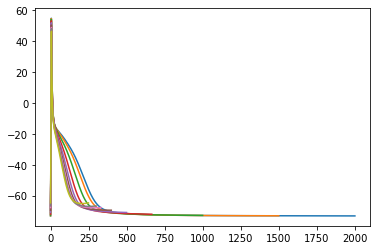

In [59]:
df = pd.DataFrame(index=legend['states']['name'])

for CL in [2000, 1500, 1000, 666, 500, 400, 333, 300, 250]:
    v = np.loadtxt(f"cases/maleckar/v0/baselines/baseline_{CL}.txt")
    s = np.loadtxt(f"cases/maleckar/v0/states/state_{CL}.txt")
    df[CL] = s
    plt.plot(v)
    
    items = ["Na_i", "Ca_rel", "K_i"]

    bounds = [6, 12], [0.01, 2], [110, 140]
    gamma = [0.15, 0.015, 0.15]

    print("{")
    print(f'"CL" : {CL},')
    print(f'"filename_phenotype": "./baseline_{CL}.txt",')
    print(f'"filename_state": "./state_{CL}.txt",')
    print('"params": [')
    for i, m in enumerate(items):
        print("\t{", end="")
        print(f'"name": "{m}",', end="")
        print(f' "bounds": {bounds[i]},', end="")
        print(f' "gamma": {gamma[i]}', end="")
        print("\t},")
    print("\t]")
    print("},")

In [64]:
#df.to_csv("cases/maleckar/v0/states_all.csv", index=True)

In [60]:
df

,2000,1500,1000,666,500,400,333,300,250
name,,,,,,,,,
V,-73.049797,-72.969364,-72.708928,-71.960107,-70.821191,-69.345669,-67.665127,-66.566930,-64.575349
Na_c,130.021473,130.020406,130.017090,130.010955,130.004829,129.999209,129.994539,129.992256,129.989108
Na_i,7.386998,7.610260,8.029832,8.612497,9.130152,9.569340,9.917256,10.092593,10.310389
m,0.003705,0.003741,0.003861,0.004229,0.004855,0.005805,0.007114,0.008124,0.010331
h1,0.855940,0.854023,0.847506,0.827309,0.793411,0.744935,0.684193,0.640485,0.548249
h2,0.855554,0.853347,0.843196,0.801455,0.728557,0.637081,0.539910,0.477609,0.360972
Ca_d,0.000060,0.000063,0.000070,0.000085,0.000106,0.000134,0.000167,0.000189,0.000229
d_L,0.000016,0.000016,0.000017,0.000019,0.000024,0.000030,0.000040,0.000049,0.000068
f_L1,0.998389,0.998371,0.998309,0.998118,0.997788,0.997286,0.996600,0.996063,0.994293


In [61]:
df_error_rel = (df_best - df[df_best.columns.to_list()]) / df[df_best.columns.to_list()] * 100

In [83]:
df_error_rel

,2000,1000,500,333,250
name,,,,,
V,0.057347,0.044848,0.013119,-0.084315,-0.141557
Na_c,-0.002783,-0.003200,-0.002932,-0.002660,-0.001922
Na_i,1.599079,1.662465,1.702169,1.615027,1.432464
m,-0.507091,-0.394896,-0.112683,0.691699,1.107196
h1,0.113035,0.095987,0.070330,-0.127012,-0.513631
h2,0.111955,0.103940,0.121095,0.046458,-0.468875
Ca_d,0.155627,0.749452,1.257610,1.316630,0.722119
d_L,-0.719407,-0.561828,-0.175044,0.904380,1.491384
f_L1,0.000946,0.000782,0.000404,-0.001760,-0.007301


In [80]:
abs(df_error_rel[250]).sort_values(ascending=False)

name
Ca_rel     2.099777
Ca_up      2.031877
d_L        1.491384
F2         1.467838
Na_i       1.432464
m          1.107196
Ca_i       1.028694
O_TC       0.967075
O_Calse    0.955710
O_C        0.931542
a_ur       0.893062
r          0.806112
Ca_d       0.722119
h1         0.513631
h2         0.468875
F1         0.407636
O_TMgC     0.237931
pa         0.219753
n          0.219483
O_TMgMg    0.177980
f_L2       0.160685
V          0.141557
K_i        0.121013
Ca_c       0.065343
s          0.061812
K_c        0.019235
O          0.015856
i_ur       0.011991
f_L1       0.007301
Na_c       0.001922
Name: 250, dtype: float64

In [1234]:
dict(zip(legend['states']['name'], S))

{'V': -64.55759565165724,
 'Na_c': 129.96356570818216,
 'Na_i': 10.272827122065559,
 'm': 0.010352893411153249,
 'h1': 0.5461223765367036,
 'h2': 0.3584288532136198,
 'Ca_d': 0.00022686556632556403,
 'd_L': 6.844640298357666e-05,
 'f_L1': 0.9942237323520401,
 'f_L2': 0.85836355462508,
 'K_c': 7.707602283075295,
 'K_i': 127.5106867237771,
 'r': 0.0025662822923989744,
 's': 0.8881820208560628,
 'a_ur': 0.0010828106445413697,
 'i_ur': 0.9104922630825888,
 'n': 0.023968930211275444,
 'pa': 0.002942865182789384,
 'Ca_c': 1.8165112009926254,
 'Ca_i': 0.0002007787173678964,
 'O_C': 0.07739932770249915,
 'O_TC': 0.038347797098216035,
 'O_TMgC': 0.42730109027483804,
 'O_TMgMg': 0.5053636556703703,
 'O': 1.4244416979141092,
 'Ca_rel': 0.9819374391618333,
 'Ca_up': 1.236053770028916,
 'O_Calse': 0.5411871439298068,
 'F1': 0.09416265183263788,
 'F2': 0.009862665096366546}

In [24]:
if False:
    for CL in baselines:
        np.savetxt(f"./cases/maleckar/baselines/baseline_{CL}.txt", baselines[CL])

    for CL in states:
        np.savetxt(f"./cases/maleckar/baselines/state_{CL}.txt", states[CL])

Toy optimization

# Polishing

In [497]:
from scipy.optimize import minimize # basinhopping, shgo, dual_annealing,

In [570]:
CL_list = [2000, 1000, 500, 333, 250]
state = {}
baseline = {}
for CL in CL_list:
    S = np.loadtxt(f"cases/maleckar/output/state/state_{CL}_{epoch}.txt")
    v = np.loadtxt(f"cases/maleckar/v0/baselines/baseline_{CL}.txt")
    
    state[CL] = S
    baseline[CL] = v

In [578]:
def f(x):
    
    multipliers_keys = ['P_Na', 'g_Ca_L',
      'g_t', 'g_kur', 'g_K1', 'g_Ks', 'g_Kr',
      'g_B_Na', 'g_B_Ca',
      'i_NaK_max', 'i_CaP_max', 'K_NaCa',
      'I_up_max', 'alpha_rel']

    multipliers_dict = dict(zip(multipliers_keys, x))
    
    S, C = init_states_constants()
    R = np.zeros_like(S)
    A = np.zeros(len(legend['algebraic']))

    C_default = pd.Series(data=C, copy=True,
                          index=legend['constants']['name'])
    update_kwargs = {}
    for key in multipliers_dict:
        update_kwargs[key] = C_default[key] * multipliers_dict[key]
    C = update_array_from_kwargs(C, legend['constants'], **update_kwargs)

    loss = 0
    
    for CL in CL_list:
    
        n_beats = 9
        stim_period = CL/1000.
        t_sampling = 1e-3

        C = update_array_from_kwargs(C, legend['constants'], stim_period=stim_period)

        config = dict(t_sampling=t_sampling,
                      n_beats=n_beats)

        S = state[CL]
        sol = run_model(S, C, R, A, config, legend, only_last_beat=True)
        res = sol.y

        state[CL] = res[:, -1]
        #print(res.shape)
        loss += calculate_RMSE(res[0, :len(baseline[CL])], baseline[CL])
        
    print(loss, x)
        
    return loss

In [579]:
f(x0)

1.0202260173241149 [0.99851707 0.75747232 1.08672165 0.67136115 0.81437239 3.17481219
 0.49728621 1.17213003 0.69585833 0.83161422 0.96616603 0.84559405
 1.22329923 1.25593275]


1.0202260173241149

In [580]:
state_copy = copy.deepcopy(state)

In [581]:
x0 = dump[-1, 0, :-1]
    
res = minimize(f, x0, method='Nelder-Mead',
               options=dict(maxiter=None, disp=True),
               tol=1e-1)

1.026007643599854 [0.99851707 0.75747232 1.08672165 0.67136115 0.81437239 3.17481219
 0.49728621 1.17213003 0.69585833 0.83161422 0.96616603 0.84559405
 1.22329923 1.25593275]
1.3701338235766467 [1.04844292 0.75747232 1.08672165 0.67136115 0.81437239 3.17481219
 0.49728621 1.17213003 0.69585833 0.83161422 0.96616603 0.84559405
 1.22329923 1.25593275]
3.1811858675001847 [0.99851707 0.79534593 1.08672165 0.67136115 0.81437239 3.17481219
 0.49728621 1.17213003 0.69585833 0.83161422 0.96616603 0.84559405
 1.22329923 1.25593275]
2.0777888253172954 [0.99851707 0.75747232 1.14105773 0.67136115 0.81437239 3.17481219
 0.49728621 1.17213003 0.69585833 0.83161422 0.96616603 0.84559405
 1.22329923 1.25593275]
2.412259998314752 [0.99851707 0.75747232 1.08672165 0.70492921 0.81437239 3.17481219
 0.49728621 1.17213003 0.69585833 0.83161422 0.96616603 0.84559405
 1.22329923 1.25593275]
4.608074105283668 [0.99851707 0.75747232 1.08672165 0.67136115 0.85509101 3.17481219
 0.49728621 1.17213003 0.6958583

KeyboardInterrupt: 

In [549]:
res.x

array([0.99851707, 0.75747232, 1.08672165, 0.67136115, 0.81437239,
       3.17481219, 0.52215052, 1.17213003, 0.69585833, 0.83161422,
       0.96616603, 0.84559405, 1.22329923, 1.25593275])

In [550]:
x0

array([0.99851707, 0.75747232, 1.08672165, 0.67136115, 0.81437239,
       3.17481219, 0.49728621, 1.17213003, 0.69585833, 0.83161422,
       0.96616603, 0.84559405, 1.22329923, 1.25593275])

In [1084]:
v_exp = np.loadtxt("../GA/setups/voigt/waveforms/0178/v_exp_250.txt")
v_model = np.loadtxt("../GA/setups/voigt/waveforms/0178/v_model_250.txt")

(0.0, 20.0)

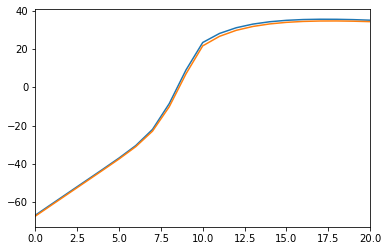

In [1089]:
plt.plot(v_exp)
plt.plot(v_model)
plt.xlim([0, 20])

(0.0, 20.0)

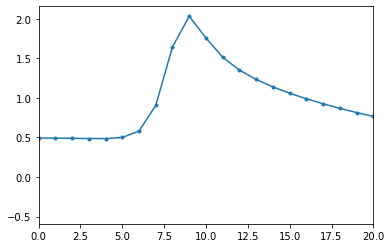

In [1088]:
plt.plot(v_exp - v_model, '.-')
plt.xlim([0, 20])

# CaT

In [2]:
from importlib import reload  

import sys
sys.path.append("../")

from src.model import maleckar_dye
from pyCardiac.routines import rescale

In [3]:
reload(maleckar_dye)

<module 'src.model.maleckar_dye' from '../src/model/maleckar_dye.py'>

In [4]:
S, C = maleckar_dye.init_states_constants()
R = np.zeros_like(S)
A = np.zeros(len(maleckar_dye.legend['algebraic']))

In [51]:
fluo_tot = 0.1
C[51] = fluo_tot

In [52]:
CL = 1000
n_beats = 10
stim_period = CL/1000.
t_sampling = 1e-3

C = update_array_from_kwargs(C, maleckar_dye.legend['constants'], stim_period=stim_period)

t_space = np.linspace(0, stim_period * n_beats, int(stim_period / t_sampling) * n_beats + 1, endpoint=True)
t_tail = np.linspace(stim_period * (n_beats - 1), stim_period * n_beats, int(stim_period / t_sampling) + 1, endpoint=True)
t_span = 0, t_space[-1]

only_last_beat = True
if only_last_beat:
    t_eval = t_tail
else:
    t_eval = t_space

sol = solve_ivp(maleckar_dye.compute_rates, y0=S,
                t_span=t_span, t_eval=t_eval,
                args=(C, R, A),
                method='LSODA',# rtol=1e-9,
                max_step=1. * t_sampling)

In [53]:
res = sol.y

df = pd.DataFrame(res.T, columns=maleckar_dye.legend['states']['name'])
#S = res[:, -1]
baseline = df['V'].values[-CL -1: -1]

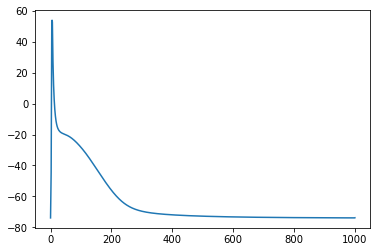

In [54]:
plt.plot(df['V'])

In [55]:
df['Fluo-3']

0       0.007873
1       0.007876
2       0.007884
3       0.007900
4       0.007957
          ...   
996     0.007881
997     0.007881
998     0.007881
999     0.007880
1000    0.007880
Name: Fluo-3, Length: 1001, dtype: float64

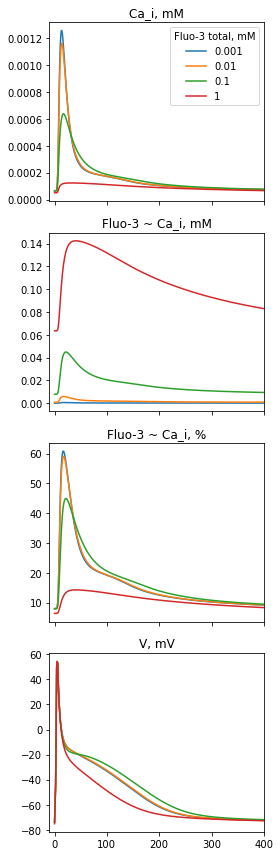

In [81]:
fig, axes = plt.subplots(nrows=4, figsize=plt.figaspect(3), sharex=True)

for fluo_tot in [0.001, 0.01, 0.1, 1]:
    
    C[51] = fluo_tot

    C = update_array_from_kwargs(C, maleckar_dye.legend['constants'], stim_period=stim_period)

    t_eval = t_tail
    sol = solve_ivp(maleckar_dye.compute_rates, y0=S,
                    t_span=t_span, t_eval=t_eval,
                    args=(C, R, A),
                    method='LSODA',# rtol=1e-9,
                    max_step=1. * t_sampling)
    
    res = sol.y

    df = pd.DataFrame(res.T, columns=maleckar_dye.legend['states']['name'])
    #S = res[:, -1]
    baseline = df['V'].values[-CL -1: -1]
    
    axes[0].plot(df['Ca_i'], label=str(fluo_tot))
    axes[1].plot(df['Fluo-3'], label=str(fluo_tot))
    axes[2].plot(df['Fluo-3'] / fluo_tot * 100, label=str(fluo_tot))
    axes[3].plot(df['V'], label=str(fluo_tot))


    #plt.plot(df['Fluo-3'] / fluo_tot, label=str(fluo_tot))
    
axes[0].legend(title='Fluo-3 total, mM')
    
axes[0].set_title('Ca_i, mM')
axes[1].set_title('Fluo-3 ~ Ca_i, mM')
axes[2].set_title('Fluo-3 ~ Ca_i, %')
axes[3].set_title('V, mV')
    
plt.xlim(-10, 400)

plt.tight_layout()
plt.savefig("../images/maleckar_dye/fluo_total_variation.png", dpi=600, facecolor='white')

<Figure size 432x288 with 0 Axes>

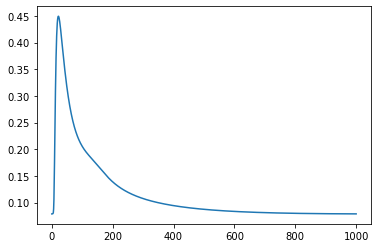

In [56]:
plt.plot(df['Fluo-3'] / fluo_tot)

In [57]:
!ls

Analysis.ipynb	      GA.ipynb		   Maleckar.ipynb     Rastrigin.ipynb
Analysis_Syn.ipynb    Kernik_Clancy.ipynb  Model.ipynb	      Rheeda.ipynb
CellMl.ipynb	      Koivumaki.ipynb	   Model_Chain.ipynb  Rosen.ipynb
Clustering.ipynb      LSODA.ipynb	   Nelder_Mead.ipynb  Tissue.ipynb
Config_creator.ipynb  Loss.ipynb	   PSO.ipynb	      Voigt.ipynb


In [58]:
#!mkdir images/maleckar_dye

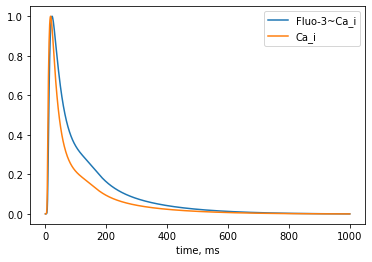

In [59]:
plt.plot(rescale(df['Fluo-3']), label='Fluo-3~Ca_i')
plt.plot(rescale(df['Ca_i']), label='Ca_i')
#plt.plot(df['Fluo-3'])
#plt.plot(df['Ca_i'])
#plt.xlim(right=300)
plt.xlabel('time, ms')
plt.legend()
#plt.savefig("images/maleckar_dye/Ca_i_model.png", dpi=300)

In [34]:
predicate = lambda x: x >= 100
def find_index_first(seq, condition):
    return next((i for i, x in enumerate(seq) if condition(x)), len(seq))

In [35]:
find_index_first(seq, predicate)

5

In [5]:
x is np.NINF

True

In [319]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [17]:
from scipy.signal import savgol_filter

In [19]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [20]:
group_indices = [1, 2, 3, 4]
cell_indices = [3, 4, 5, 8]

CL = 1032

df_CaT = pd.read_csv("/home/andrey/Dropbox/Voigt/voigt_CaT_params.csv")
df_CaT.set_index(['Group', 'Cell'], inplace=True)

fig, axes = plt.subplots(2, 2, sharex='col', sharey='row')
i_ax = 0

for g_index in [1, 2, 3, 4]:
    
    plt.sca(axes.flatten()[i_ax])
    i_ax += 1
        
    for c_index in range(1, cell_indices[g_index-1] + 1):
        exp = np.loadtxt(f"/home/andrey/WORK/HPL/projects/voigt/Action_potentials_AG_Voigt/chosen_sweeps/{g_index}_{c_index}_{CL}.txt")

        FBL, Fmax = df_CaT.loc[(g_index, c_index), :]
        K = 864 / 1000
        F = exp[:, -1]
        CaT = K * (F - FBL) / (Fmax - F)
        #CaT = moving_average(CaT, 333)
        CaT = savgol_filter(CaT, 101, 1)
        
        t = np.arange(len(CaT)) / 10
        plt.plot(t, rescale(CaT))
        
        plt.plot(rescale(df['Fluo-3']), 'k', label='Fluo-3~Ca_i')
        plt.plot(rescale(df['Ca_i']), 'k', label='Ca_i')
        
    plt.grid()
    plt.title(f"Group {g_index}")
    if g_index >= 3:
        plt.xlabel("time, ms")

#plt.savefig("./images/maleckar_dye/vanessa_CaT.png", dpi=300)
plt.show()  

In [10]:
exp = np.loadtxt("../Data/Action_potentials_AG_Voigt/chosen_sweeps/2_2_1032.txt")

In [259]:
df_CaT = pd.read_csv("/home/andrey/Dropbox/Voigt/voigt_CaT_params.csv")
df_CaT.set_index(['Group', 'Cell'], inplace=True)

In [260]:
df_CaT.head()

FBL     FMAX
Group Cell                  
1     1     1.48315  1.52832
      2     1.48358  1.54740
      3     1.48694  1.60256
2     1     1.68824  1.76628
      2     1.48679  1.53248

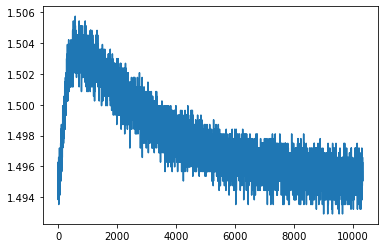

In [11]:
plt.plot(exp[:, -1])

In [25]:
FBL, Fmax = df_CaT.loc[(2, 2), :]
K = 864
F = exp[:, -1]
CaT = K * (F - FBL) / (Fmax - F)

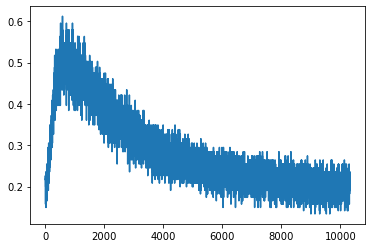

In [29]:
plt.plot(CaT / 1000)